In [192]:
## Installing some libraries and packages.
%pip install pandas numpy matplotlib seaborn nltk scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\assignment 3\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet # For POS tagging if doing advanced lemmatization

In [194]:
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [195]:
np.random.seed(42)
tf.random.set_seed(41)

## Loading the dataset

In [196]:
df = pd.read_csv("Airline_Reviews.csv")
# We have to drop the rest and keep the only relevant information for our project
# df = df[["Review", "Overall_Rating"]].dropna()
# Convert 'Overall_Rating' to numeric, coercing errors
df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce')
# Drop rows where 'Overall_Rating' is NaN after conversion
df = df.dropna(subset=['Overall_Rating'])
df = df[["Review", "Overall_Rating"]].dropna()

df.head()

,Review,Overall_Rating
0,Moroni to Moheli. Turned out to be a pretty ...,9.0
1,Moroni to Anjouan. It is a very small airline...,1.0
2,Anjouan to Dzaoudzi. A very small airline an...,1.0
3,Please do a favor yourself and do not fly wi...,1.0
4,Do not book a flight with this airline! My fr...,1.0


In [197]:
## Check if there is null values
df.isnull().sum()

Review            0
Overall_Rating    0
dtype: int64

In [198]:
# # Splitting data into dependent and independent variables 
# X = df["Review"]
# y = df["Overall_Rating"]

In [199]:
# # Splitting data into train and test dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Data Preprocessing

In [200]:
# A function that handles the data preprocessing
def preprocess_text(text):
    # Handle non-string inputs
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags if there
    text = re.sub(r'<.*?>', "", text)
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z\s]', " ", text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [
        word for word in tokens if word not in stop_words and len(word) > 1]

    # Lemantization

    """Because lemmatization produces actual words, the processed text is more 
    human-readable and often leads to more accurate results in downstream natural language processing (NLP) tasks.
    because we are dealing with sentiment analysis, understanding the actual meaning of words is crucial and hence lemmatization."""
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    return ' '.join(tokens)

In [201]:
# Apply the preprocessing function to the 'Review' column and create a new 'Processed_Review' column
df['Processed_Review'] = df['Review'].apply(preprocess_text)

# Splitting data into dependent and independent variables
X = df["Processed_Review"]  # Use the processed column
y = df["Overall_Rating"]

### We then group the ratings for balancing the data

In [202]:
def map_rating_to_sentiment(rating):
    rating = int(rating)  # Ensure rating is an integer
    if 1 <= rating <= 3:
        return 0  # Negative
    elif 4 <= rating <= 6:
        return 1  # Neutral
    elif 7 <= rating <= 10:
        return 2  # Positive
    return None  # Should not happen if data is clean


df['Overall_Rating'] = df['Overall_Rating'].apply(map_rating_to_sentiment)
# Drop any rows where mapping might have failed (if any rating was outside 1-10 initially)
df = df.dropna(subset=['Overall_Rating'])
df['Overall_Rating'] = df['Overall_Rating'].astype(int)

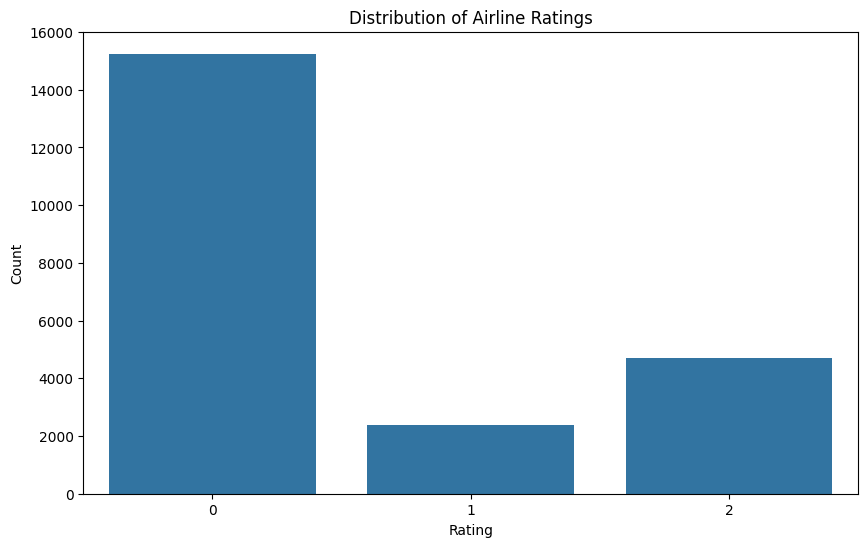

In [203]:
# Visualize rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Overall_Rating', data=df)
plt.title('Distribution of Airline Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [204]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Processed_Review'],
    df['Overall_Rating'],
    test_size=0.2,
    random_state=42,
    stratify=df['Overall_Rating']
)

In [205]:
df

,Review,Overall_Rating,Processed_Review
0,Moroni to Moheli. Turned out to be a pretty ...,2,moroni moheli turned pretty decent airline onl...
1,Moroni to Anjouan. It is a very small airline...,0,moroni anjouan small airline ticket advised tu...
2,Anjouan to Dzaoudzi. A very small airline an...,0,anjouan dzaoudzi small airline airline based c...
3,Please do a favor yourself and do not fly wi...,0,please favor fly adria route munich pristina j...
4,Do not book a flight with this airline! My fr...,0,book flight airline friend returned sofia amst...
...,...,...,...
23166,Bangkok to Tokyo. I’ve flown many low cost ai...,0,bangkok tokyo flown many low cost airline stil...
23167,Avoid at all costs. I booked flights to go f...,0,avoid cost booked flight go singapore tokyo du...
23168,Flight was leaving at 23.15 and after an hou...,0,flight leaving hour half flying get back airpo...
23169,Zipair is JAL’s budget airline. They don’t ha...,1,zipair jal budget airline class travel pick se...


In [206]:
y_train.head()

1671     0
4726     0
14897    2
2656     2
1292     0
Name: Overall_Rating, dtype: int64

## Embeddings

In [207]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=3000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [208]:
sample_tfidf = X_train_tfidf[:5, :100].toarray()
print(sample_tfidf)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.11226175 0.         0.16450538
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.10434559 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.21625245 0.         0.         0.
  0.         0.         0.         0.         0.02746329 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.      

In [209]:
# Prepare the labels (subtract 1 to make ratings 0-based for compatibility with softmax)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [210]:
# Convert to one-hot encoded vectors
num_classes = len(np.unique(y_train_encoded))
y_train_categorical = tf.keras.utils.to_categorical(
    y_train_encoded, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

In [211]:
# Calculate class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = dict(enumerate(class_weights))

## Build the model

In [212]:
def build_the_model(input_dim, output_dim):
  model = Sequential([
      Dense(64, activation='relu', input_dim=input_dim,
            kernel_regularizer=regularizers.l2(0.01)),
      Dropout(0.5),
      Dense(64, activation='relu',
            kernel_regularizer=regularizers.l2(0.01)),
      Dropout(0.5),
      Dense(output_dim, activation='softmax')
  ])

  model.compile(
      optimizer=Adam(learning_rate=0.0001),
      loss="categorical_crossentropy",
      metrics=["accuracy"]
  )

  return model

In [213]:
# Create and train the model
model = build_the_model(X_train_tfidf.shape[1], num_classes)
# model.summary

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
)

train_the_model = model.fit(
    X_train_tfidf,
    y_train_categorical,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
    verbose=1
)

d:\assignment 3\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4234 - loss: 2.6268 - val_accuracy: 0.6930 - val_loss: 1.8805
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6217 - loss: 1.7620 - val_accuracy: 0.7445 - val_loss: 1.4712
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7047 - loss: 1.4441 - val_accuracy: 0.7554 - val_loss: 1.2726
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7260 - loss: 1.2884 - val_accuracy: 0.7509 - val_loss: 1.1346
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7317 - loss: 1.1843 - val_accuracy: 0.7517 - val_loss: 1.0381
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7388 - loss: 1.1102 - val_accuracy: 0.7481 - val_loss: 0.9758
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7369 - loss: 1.0616 - val_accuracy: 0.7470 - val_loss: 0.9316
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7393 - loss: 1.0243 - val_accu

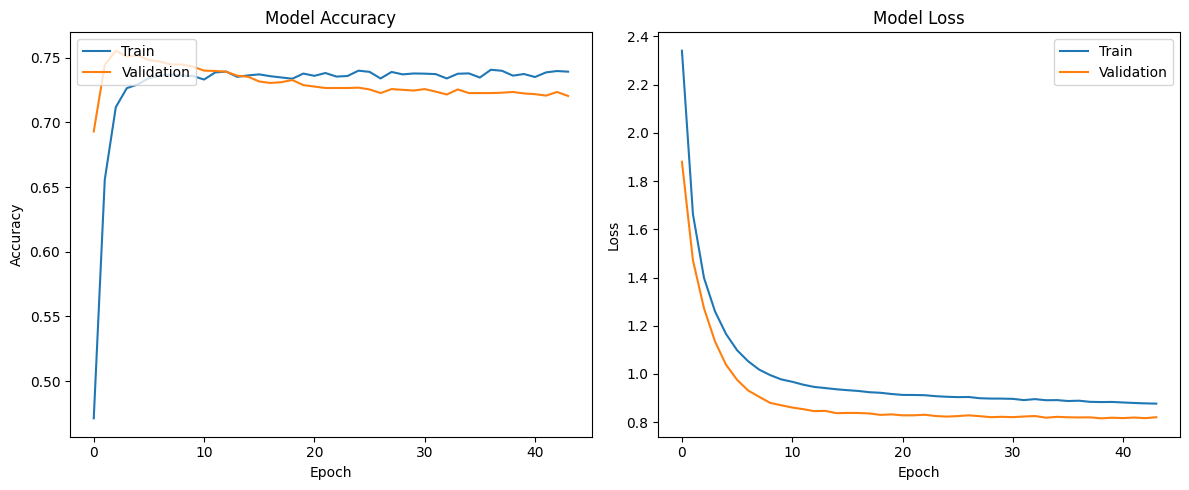

In [214]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_the_model.history['accuracy'])
plt.plot(train_the_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_the_model.history['loss'])
plt.plot(train_the_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

In [215]:
y_pred_probs = model.predict(X_test_tfidf)
y_predict = np.argmax(y_pred_probs, axis=1)

# Print evaluation metrics
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_predict):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_predict))

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model Evaluation:
Accuracy: 0.7351

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      3050
           1       0.25      0.37      0.30       473
           2       0.60      0.77      0.67       943

    accuracy                           0.74      4466
   macro avg       0.59      0.64      0.61      4466
weighted avg       0.79      0.74      0.75      4466



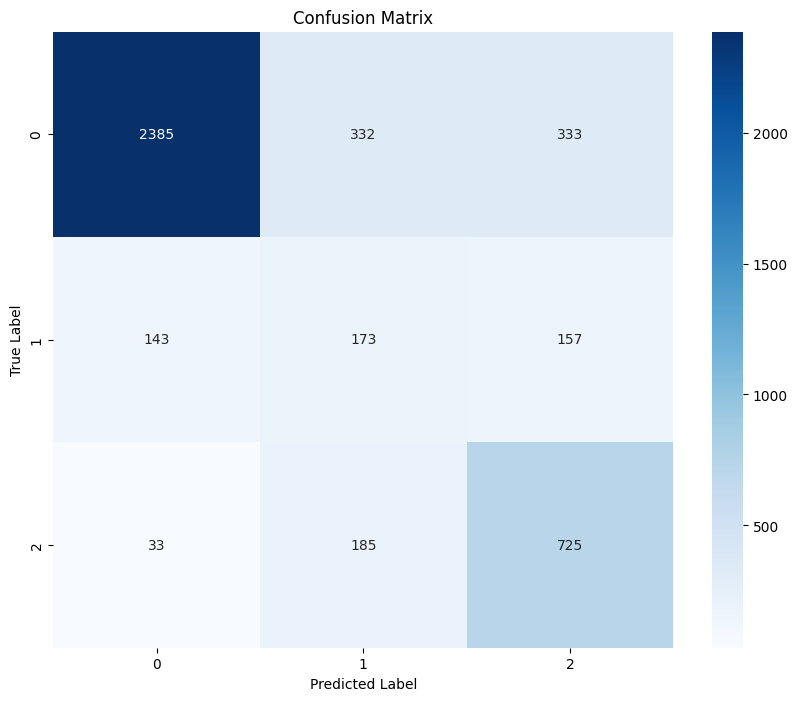

In [216]:
# confusion matrix plot
cm = confusion_matrix(y_test_encoded, y_predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
plt.close()

## Model Prediction

In [217]:
# Function to predict rating for a new review
def predict_rating(review_text):
    # Preprocess the review
    processed_review = preprocess_text(review_text)
    # Transform to TF-IDF features
    review_tfidf = tfidf_vectorizer.transform([processed_review]).toarray()
    # Make prediction
    pred_probs = model.predict(review_tfidf)[0]
    pred_class = np.argmax(pred_probs)
    # Map back to original rating (add 1 since we subtracted 1 earlier)
    predicted_rating = label_encoder.inverse_transform([pred_class])[0]

    return predicted_rating, pred_probs

In [218]:
example_text = [
    "Flying with SkyJet Airways in business class from London to Tokyo was a dream. The seats were fully lie-flat, the food was gourmet quality, and the flight attendants were incredibly attentive. I especially appreciated the amenity kit and fast Wi-Fi. Worth every penny!",
    "Absolutely the worst experience with AeroLink. My flight from Chicago to Dallas was delayed for 6 hours with zero communication. Once onboard, the seats were cramped, dirty, and the staff were rude. No compensation or apology. Never again.",
    "I flew with JetSaver from Berlin to Madrid. It was fine for a budget airline—nothing special. The check-in process was slow, but we departed on time. No in-flight entertainment, and food was overpriced, but the staff were polite. You get what you pay for.",
    "We flew GlobalWings from New York to Paris with our two kids, and it was surprisingly smooth. The staff were very helpful with the children, the in-flight entertainment had great kid-friendly options, and we landed early. Will definitely fly with them again!",
    "Missed my connecting flight with AirNova because of a delayed inbound flight, and the ground staff offered no assistance. They made me rebook at my own cost. Poor customer service and lack of accountability. Extremely disappointed."
]

for review in example_text:
  rating, probs = predict_rating(review)
  print(f"Review: \n {review}")
  print(f"Rating: \n {rating}")
  print(f"Confidence: \n {probs}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Review: 
 Flying with SkyJet Airways in business class from London to Tokyo was a dream. The seats were fully lie-flat, the food was gourmet quality, and the flight attendants were incredibly attentive. I especially appreciated the amenity kit and fast Wi-Fi. Worth every penny!
Rating: 
 2
Confidence: 
 [0.14996678 0.40356916 0.44646406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Review: 
 Absolutely the worst experience with AeroLink. My flight from Chicago to Dallas was delayed for 6 hours with zero communication. Once onboard, the seats were cramped, dirty, and the staff were rude. No compensation or apology. Never again.
Rating: 
 0
Confidence: 
 [0.88980186 0.10294536 0.00725278]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Review: 
 I flew with JetSaver from Berlin to Madrid. It was fine for a budget airline—nothing special. The check-in process was slow, but we departed on time. No in-flight entertainment, and food was overpriced, but the staff were po